# Prepare data

Total run time: approx. 10 min

### 1. Helper methods

We will be using GTSRB dataset (German Traffic Sign Recognition Benchmark) from http://benchmark.ini.rub.de/?section=gtsrb&subsection=news.
Available datasets are train and test. We will further split train set to train and validation.

#### Notebook setup

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import os
import pandas as pd
import PIL
from PIL import Image
from tqdm.notebook import trange, tqdm
from time import sleep

In [3]:
import datetime
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-01 22:54:53.511108


In [4]:
# helper methods

def get_sign_count(dataset):
    labels = np.zeros(len(dataset.classes))
    progress_bar = tqdm(range(len(dataset)), desc='Counting files in each class')
    for i in range(len(dataset)):
        x,y = dataset[i]
        labels[y] +=1
        progress_bar.update()
    count = np.array(labels, dtype=int)
    return count

def vis_sign_count(count):
    print('Smallest class: '+str(min(count)))
    print('Biggest class:  '+str(max(count)))

    classes = np.arange(len(count))
    plt.bar(classes, count)
    plt.xlabel('Signs')
    plt.ylabel('Count')
    plt.title('Count of signs in each class')
    plt.show()

In [5]:
# tack helper methods

def get_track_count(input_images_root):
    track_count = pd.DataFrame(columns=['class_id','track_count'])
    with os.scandir(input_images_root) as images_it:
        progress_bar = tqdm(range(43), desc='Counting tracks in each class')
        for class_id in images_it:
            if class_id.is_dir():# and class_id.name.startswith('00000'):
                with os.scandir(input_images_root+'/'+class_id.name) as class_it:
                    #print(input_images_root+'/'+class_id.name)
                    df = pd.DataFrame(columns=['name'])
                    for entry in class_it:
                        if entry.is_file() and entry.name.endswith('.ppm'):
                            df = df.append({'name':entry.name, 'track':entry.name[:entry.name.rfind("_")]}, ignore_index=True) 
                    track_count = track_count.append({'class_id':class_id.name, 'track_count':len(df.track.unique())}, ignore_index=True)        
            progress_bar.update()
    track_count = track_count.sort_values(by=['class_id'])
    return track_count

def vis_track_count(track_count):
    print('Lowest number of tracks per class: '+str(min(track_count['track_count'])))
    print('Highest number of tracks per class:  '+str(max(track_count['track_count'])))
    
    classes = np.arange(len(track_count['track_count']))
    plt.bar(classes, track_count['track_count'], color='green')
    plt.xlabel('Tracks')
    plt.ylabel('Count')
    plt.title('Count of tracks in each class')
    plt.show()


### Preparing data for training

#### Data augmentation by reuse and rotation

Despite the overall size of the data set, when taking into account a high number of classes and the correlation within tracks, the data is smaller than it seems. As noticed by some researchers (for example [here](https://medium.com/@wolfapple/traffic-sign-recognition-2b0c3835e104), although the author made an error for the roundabout sign) it can be extended by rotating some signs or flipping and reusing for other class. For example left and right turn signs can be reused, and give way sign has horizontal symetry.<br>
<br>
Classes which can reuse images flipped horizontally from other class: (19,20), (33,34), (36,37), (38,39)<br>
Classes with horizontal symmetry: 11, 12, 13, 15, 17, 18, 22, 26, 30, 35<br>
Classes with vertical symmetry: 01, 05, 12, 15, 17<br>
Classes which can be rotated by 120 or 240 degrees: 40<br>
Classes which can be rotated by any degree: 15<br>
Classes which diagonal symetry : 32<br>
<br>
Let's create a new data source directory which will include reused images.<br> 
I'll also change classes to 2 digits in the new dataset.

In [6]:
# first copy all .ppm files to new location using new class names
input_images_root = './source_data/train/GTSRB/Final_Training/Images'
output_images_root = './source_data_2/train'

os.makedirs(output_images_root, exist_ok=True)
with os.scandir(input_images_root) as images_it:
    progress_bar = tqdm(range(43), desc='Copying files in each class')
    for class_id in images_it:
        if class_id.is_dir(): #and class_id.name.startswith('00000'):
            os.makedirs(output_images_root+'/'+class_id.name[-2:], exist_ok=True)
            with os.scandir(input_images_root+'/'+class_id.name) as class_it:
                #print(input_images_root+'/'+class_id.name)
                for entry in class_it:
                    if entry.is_file() and entry.name.endswith('.ppm'):
                        os.system('cp {} {}'.format(input_images_root+'/'+class_id.name+'/'+entry.name,
                                 output_images_root+'/'+class_id.name[-2:]+'/'+entry.name))  
            progress_bar.update()

In [7]:
#transforms

def transpose_image(image_path, save_path, transpose_1st=None, transpose_2nd=None, rotate_1st=None, rotate_2nd=None):
    """
    Transpose and rotate the given photo once or twice and save it
    @param image_path: The path to the input image
    @param transpose_1st: one of 
    @param transpose_2nd: one of 
        PIL.Image.FLIP_LEFT_RIGHT, 
        PIL.Image.FLIP_TOP_BOTTOM, 
        PIL.Image.ROTATE_90, 
        PIL.Image.ROTATE_180, 
        PIL.Image.ROTATE_270 or 
        PIL.Image.TRANSPOSE
    @param rotate_1st: degree to rotate, anti-clockwise 
    @param rotate_2nd: degree to rotate, anti-clockwise 
    @param save_path: Path to save the image
    """
    image_in = Image.open(image_path)
    if transpose_1st != None:
        image_out = image_in.transpose(transpose_1st)
        image_in = image_out 
    if transpose_2nd != None:
        image_out = image_in.transpose(transpose_2nd)
        image_in = image_out 
    if rotate_1st != None:
        image_out = image_in.rotate(rotate_1st)
        image_in = image_out 
    if rotate_2nd != None:
        image_out = image_in.rotate(rotate_2nd)
    image_out.save(save_path)



def transpose_class(class_id, prefix, transpose_1st=None, transpose_2nd=None, rotate_1st=None, rotate_2nd=None, together=True):
    with os.scandir(output_images_root+'/'+class_id) as class_it:
        if together:
            #apply both transforms or rotations to each file
            for entry in class_it:
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_1st=transpose_1st, transpose_2nd=transpose_2nd, rotate_1st=rotate_1st, rotate_2nd=rotate_2nd)
        else:
            #first create images with 1st transform/rotate and then second set of images with 2nd transform
            #iterators in Python run only once, so we save the input and create new iters for each loop
            files = list(class_it)
            for entry in iter(files):
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_1_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_1st=transpose_1st, rotate_1st=rotate_1st)
            for entry in iter(files):
                image_path = output_images_root+'/'+class_id+'/'+entry.name
                save_path = output_images_root+'/'+class_id+'/'+prefix+'_2_'+entry.name
#                print('{} -> {}'.format(image_path, save_path))
                transpose_image(image_path, save_path, transpose_2nd=transpose_2nd, rotate_2nd=rotate_2nd)


def duplicate_class_horizontally(class_id_1, class_id_2):
    class_it_1 = list(os.scandir(output_images_root+'/'+class_id_1))
    class_it_2 = list(os.scandir(output_images_root+'/'+class_id_2))
    for entry_1 in iter(class_it_1):
        os.system('cp {} {}'.format(output_images_root+'/'+class_id_1+'/'+entry_1.name,
                                    output_images_root+'/'+class_id_2+'/'+'from_'+class_id_1+'_'+entry_1.name))
    for entry_2 in iter(class_it_2):
        os.system('cp {} {}'.format(output_images_root+'/'+class_id_2+'/'+entry_2.name,
                                    output_images_root+'/'+class_id_1+'/'+'from_'+class_id_2+'_'+entry_2.name))
        
 

In [8]:
#apply transforms

output_images_root = './source_data_2/train'
h_sym = ['11', '12', '13', '15', '17', '18', '22', '26', '30', '35']
v_sym = ['01', '05', '12', '15', '17']
r_120_240 = ['40', '15']
hv_flip = ['32']
h_duplicate = [['19','20'], ['33','34'], ['36','37'], ['38','39']]

#Test
#output_images_root = './testing_transforms/train'
#h_sym = ['1']
#v_sym = ['2']
#r_120_240 = ['3', '4']
#hv_flip = ['5']
#h_duplicate = [['1','2'], ['3','4']]

progress_bar1 = tqdm(range(len(h_sym)), desc='Flipping horizontally')
for class_id in h_sym:
    transpose_class(class_id, prefix='hflip', transpose_1st=Image.FLIP_LEFT_RIGHT, together=True)
    sleep(0.01) # progress bar sometimes don't update if update() is called too quickly
    progress_bar1.update()

progress_bar2 = tqdm(range(len(v_sym)), desc='Flipping vertically')
for class_id in v_sym:
    transpose_class(class_id, prefix='vflip', transpose_1st=Image.FLIP_TOP_BOTTOM, together=True)
    sleep(0.01)
    progress_bar2.update()

progress_bar3 = tqdm(range(len(r_120_240)), desc='Rotating')
for class_id in r_120_240:
    transpose_class(class_id, prefix='rot', rotate_1st=120, rotate_2nd=240, together=False)
    sleep(0.01)
    progress_bar3.update()

progress_bar4 = tqdm(range(len(hv_flip)), desc='Flipping horiz and vert')
for class_id in hv_flip:
    transpose_class(class_id, prefix='hv_flip', 
                    transpose_1st=Image.FLIP_LEFT_RIGHT, 
                    transpose_2nd=Image.FLIP_TOP_BOTTOM, together=True)
    sleep(0.1)
    progress_bar4.update()
    
progress_bar5 = tqdm(range(len(h_duplicate)), desc='Copying to symmetric class')
for pair in h_duplicate:
    duplicate_class_horizontally(pair[0], pair[1])
    sleep(0.01)
    progress_bar5.update()

Let's check how class count looks after these changes

Smallest class: 210
Biggest class:  13200


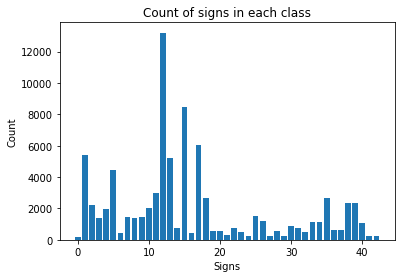

In [9]:
#Check data distribution after data reuse

train_dataset_2 = datasets.ImageFolder('./source_data_2/train/')
sign_count_2 = get_sign_count(train_dataset_2)
vis_sign_count(sign_count_2)

Lowest number of tracks per class: 7
Highest number of tracks per class:  1087


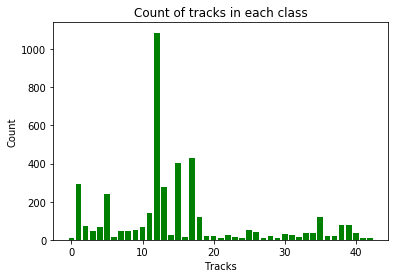

In [10]:
track_count = get_track_count('./source_data_2/train/')
vis_track_count(track_count)

We now have much more training data but some small classes didn't change, for example "20 speed limit". We will need to take class imbalance into consideration during training.

#### Split train set into train and validation sets

In [11]:
train_images_root = './source_data_2/train/'
valid_images_root = './source_data_2/valid/'

def train_valid_split(train_images_root, valid_images_root, train_validation_ratio = 0.1, min_track = 1):
    os.makedirs(valid_images_root, exist_ok=True)
    progress_bar_classes = tqdm(range(len(track_count)), desc='Extracting validation tracks')
    for index, row in track_count.iterrows():
        class_id = row['class_id']
        #select at least min_track tracks for validataion set
        valid_count= max(min_track,round(row['track_count'] * train_validation_ratio))
        os.makedirs(valid_images_root+class_id, exist_ok=True)
        with os.scandir(train_images_root + class_id) as images_it:
            images = list(images_it)
            images_tracks = pd.DataFrame(images)
            images_tracks['track'] = [image.name[:image.name.rfind("_")] for image in images_tracks[0]]
            sampled_track_list = random.sample(list(images_tracks['track']), valid_count)
            for sampled_track in iter(sampled_track_list):
                sampled_images=images_tracks[images_tracks['track']==sampled_track][0]
                for image in sampled_images:
                    os.system('mv {} {}'.format(train_images_root+class_id+'/'+image.name,
                                            valid_images_root+class_id+'/'+image.name))
        progress_bar_classes.update()
                    
train_valid_split(train_images_root, valid_images_root, train_validation_ratio = 0.1, min_track = 1)

#### Prepare test set

For test set we will use GTSRB Test set that we downloaded to source_data/test.
This dataset comprises of files all in one directory and a CSV file with Ground Truth labels.
We will copy it to the same file structure as /train and /valid sets, also using the same class names.

In [12]:
test_images_input_path = './source_data/test/GTSRB/Final_Test/Images/'
test_lables_input_path = './source_data/test/GT-final_test.csv'
test_images_output_path  = './source_data_2/test/'

def prepare_test_data(test_images_input_path, test_lables_input_path, test_images_output_path):
    gt_data = pd.read_csv(test_lables_input_path, header=0, sep=';')
    gt_data['_00ClassId'] = gt_data.ClassId.astype(str).str.zfill(2)
    classes = pd.unique(gt_data['_00ClassId'])
    for class_id in pd.unique(gt_data['_00ClassId']):
        os.makedirs(test_images_output_path+class_id, exist_ok=True)

    progress_bar = tqdm(range(len(gt_data.index)), desc='Copying test classes')
    for index, row in gt_data.iterrows():
        class_id = row['_00ClassId']
        os.system('cp {} {}'.format(test_images_input_path+row['Filename'],
                                    test_images_output_path+class_id+'/'+row['Filename']))
        progress_bar.update()

        
prepare_test_data(test_images_input_path, test_lables_input_path, test_images_output_path)

### Investigating class imbalance

The data has high imbalance so we risk that the model would favour bigger classes as more probable based on input distribution, not features. The imbalace got even worse after reusing images because some small classes like "speed limit to 20" could not benefit from it.<br>

There are multiple ways to address it. One would be to add weights to loss function during training (for example https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss). However, with over 10x difference between biggest and smallest classes, rare samples from small classes would be giving high error input to back propagation and the model might be difficult to train. <br>
Another approach could be data augmentation based on class weights, to equalize class sizes in training set. Traffic signs are good candidates for augmentation because we can apply some affine transformations or rotate by small angles. <br>

For now, let's save sign counts in each class, after validation tracks are extracted, to later calculate weights.

In [13]:
train_dataset_2_final = datasets.ImageFolder('./source_data_2/train/')
sign_count_2_final = get_sign_count(train_dataset_2_final)

#save sign count for later use
sign_count_2_final_df = pd.DataFrame(sign_count_2_final, columns=['count'])
sign_count_2_final_df.to_csv('sign_count.csv', index_label='class_id')

In [14]:
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-01 23:04:21.254409
